In [1]:
import numpy as np
from nbodykit.lab import *
from nbodykit.transform import CartesianToEquatorial
import healpy as hp
import h5py 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

root = 0
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

sim = 'rfof_proc64_nc512_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/'
prtl = BigFileCatalog(f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/{sim}/usmesh', dataset='1')

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [2]:
# obtain real field
mesh_name = f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/{sim}'
mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK', comm=comm)
mesh_kr = mesh_k.compute(mode='real')

In [3]:
delta = mesh_kr[::2,::2,::2].flatten()  # unroll deltas, and subsample x2 from force grid

In [ ]:
np.max(prtl["ID"]).compute() + 1, delta.shape  # IDs size should be same as subsampled force grid

In [4]:
def read_range(cat, amin, amax):  # Yici gave this to me
    """ Read a portion of the lightcone between two red shift ranges
        The lightcone from FastPM is sorted in Aemit and an index is built.
        So we make use of that.
        CrowCanyon is z > 0; We paste the mirror image to form a full sky.
    """
    edges = cat.attrs['aemitIndex.edges']
    offsets = cat.attrs['aemitIndex.offset']
    start, end = edges.searchsorted([amin, amax])
    if cat.comm.rank == 0:
        cat.logger.info("Range of index is %d to %d" %(( start + 1, end + 1)))
    start = offsets[start + 1]
    end = offsets[end + 1]
    cat =  cat.query_range(start, end)
    #cat1 = cat.copy()
    #cat1['Position'] = cat1['Position'] * [1, 1, -1.]
    #cat3 = ConcatenateSources(cat, cat1)
    if cat.csize > 0:
        cat['RA'], cat['DEC'] = CartesianToEquatorial(cat['Position'], frame='galactic')
    else:
        cat['RA'] = 0
        cat['DEC'] = 0
    return cat  # returns RA, DEC in degrees

In [5]:
# get particle locations
amin, amax = 0.45, 0.55
cat = read_range(prtl, amin, amax)
nside = 128
npix = hp.nside2npix(nside)
hp_ind = hp.ang2pix(nside, cat["RA"], cat["DEC"], lonlat=True).compute()

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [6]:
# get deltas based on particle ID
delta_at_particle = delta[np.array(cat['ID'])]

# set up some arrays for maps
particlemap, densitymap = np.zeros(npix), np.zeros(npix)

# add at pixel locations
np.add.at(particlemap, hp_ind, 1)
np.add.at(densitymap, hp_ind, delta_at_particle)

# normalize
particlemap = particlemap / np.mean(particlemap) - 1
densitymap = densitymap / np.mean(densitymap) - 1

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [7]:
np.sum(delta_at_particle) / len(cat["RA"])  # deltas are mean 1

1.0005216578729783

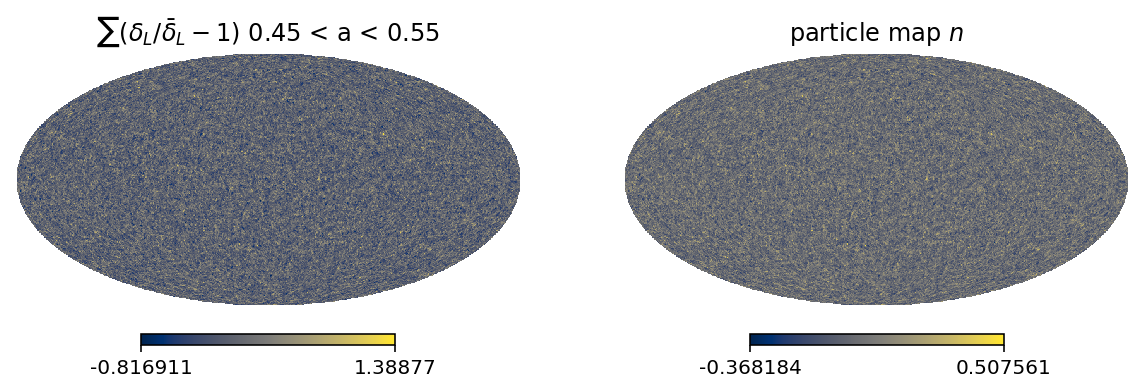

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.sca(ax[0])
hp.mollview(densitymap, cmap="cividis", hold=True,
            title=r"$\sum (\delta_L / \bar{\delta}_L-1)$ " + f"{amin} < a < {amax}")
plt.sca(ax[1])
hp.mollview(particlemap, cmap="cividis", hold=True,
            title="particle map $n$")

Text(0.5, 0, 'Multipole moment, $\\ell$')

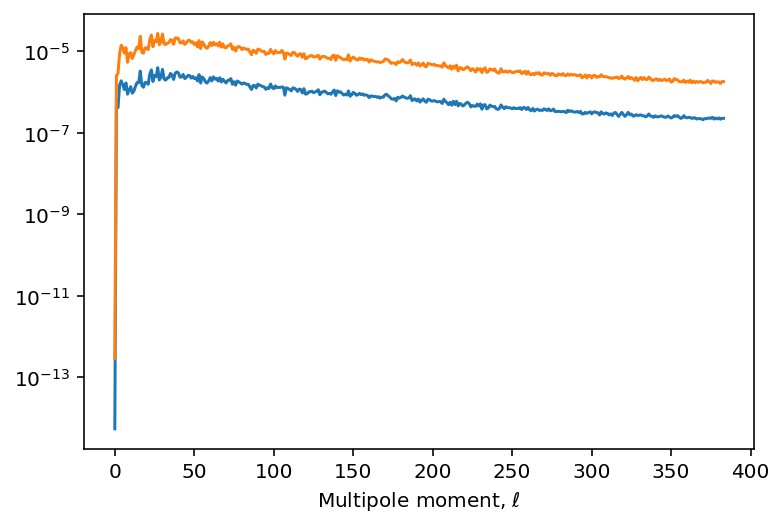

In [9]:
alm_particles = hp.map2alm(particlemap)
alm_density = hp.map2alm(densitymap)

plt.plot(hp.alm2cl(alm_particles), label="Auto-spectrum of particles, $n$")
plt.plot(hp.alm2cl(alm_density), label=r"Auto-spectrum $(\rho / \bar{\rho}-1)$ at particle locations")
# plt.plot(hp.alm2cl(alm_particles, alm_density), label=r"Cross-spectrum $n$ and $(\rho / \bar{\rho}-1)$")
plt.yscale("log"); plt.xlabel("Multipole moment, $\ell$")

Text(0.5, 0, 'Multipole moment, $\\ell$')

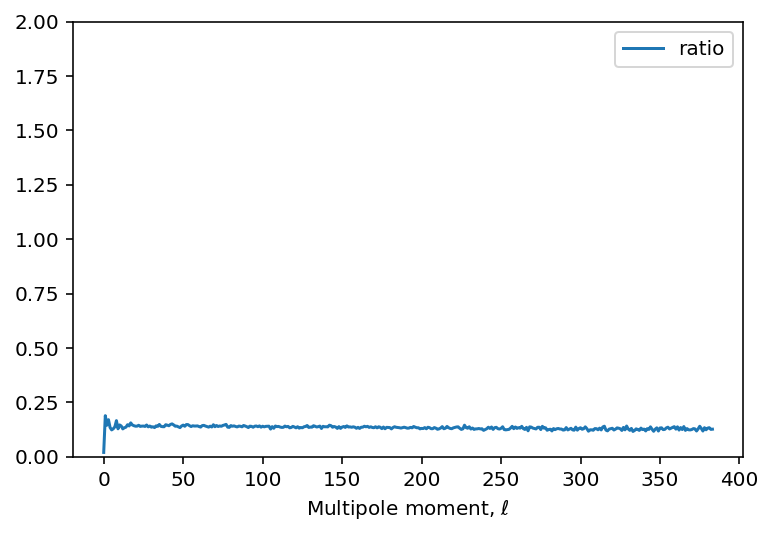

In [10]:
plt.plot(hp.alm2cl(alm_particles) / hp.alm2cl(alm_density), label="ratio")
plt.legend(); plt.ylim(0,2); plt.xlabel("Multipole moment, $\ell$")

In [ ]:
for a in (0.3, 0.5, 0.7, 0.9):
    amin, amax = a - 0.05, a + 0.05
    cat = read_range(prtl, amin, amax)
    hp_ind = hp.ang2pix(nside, cat["RA"], cat["DEC"], lonlat=True).compute()
    delta_at_particle = delta[np.array(cat['ID'])]
    particlemap, densitymap, shuffledensitymap = np.zeros(npix), np.zeros(npix), np.zeros(npix)
    np.add.at(particlemap, hp_ind, 1)
    np.add.at(densitymap, hp_ind, delta_at_particle)
    particlemap = particlemap / np.mean(particlemap) - 1
    densitymap = densitymap / np.mean(densitymap) - 1
    alm_particles = hp.map2alm(particlemap)
    alm_density = hp.map2alm(densitymap)
    plt.plot(hp.alm2cl(alm_particles) / hp.alm2cl(alm_density), label=f"{amin}<a<{amax}")
plt.legend(); plt.ylim(0,2); plt.xlabel("Multipole moment, $\ell$")

# 3d test

In [12]:
# get deltas based on particle ID for 3d case
delta_at_particle_3d = delta[np.array(prtl['ID'])]

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [14]:
# add column to catalog for delta_at_particle
prtl['delta'] = delta_at_particle_3d

In [26]:
# paint to 3d mesh
mesh_particles = prtl.to_mesh(window='tsc', Nmesh=64, compensated=True)
mesh_density = prtl.to_mesh(window='tsc', Nmesh=64, compensated=True, weight='delta')

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# compute power
r_particles = FFTPower(mesh_particles, mode='1d') #, dk=0.005, kmin=0.01)
r_density = FFTPower(mesh_density, mode='1d')

In [ ]:
# plot power
plt.loglog(r_particles.power['k'], r_particles.power['power'].real, label='n')
plt.loglog(r_density.power['k'], r_density.power['power'].real, label='density weighted')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel('P')

In [ ]:
# ratio
plt.loglog(r_particles.power['k'], r_particles.power['power'].real/r_density.power['power'].real)
plt.xlabel('k (h/Mpc)')
plt.ylabel('ratio')